In [ ]:
# Connect google drive and import dataset from it

from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/dataset.zip -d /content/

In [ ]:
# !pip install tensorflow==2.9.3

In [ ]:
# Import libraries

import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.9.3


In [ ]:
directory = "dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    seed=422,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training"
)

# tf.keras.utils.image_dataset_from_directory(
#     directory,
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     **kwargs
# )

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=422,
    validation_split=0.2,
    subset="validation"
)

Found 11796 files belonging to 12 classes.
Using 9437 files for training.
Found 11796 files belonging to 12 classes.
Using 2359 files for validation.


In [ ]:
# Visualize the image
# class_name = train_ds.class_names
# plt.figure(figsize=(14, 30))
# for images, labels in train_ds.take(10):
#     for i in range(32):
#         ax = plt.subplot(8, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_name[labels[i%12]],fontsize=10)
#         plt.axis("off")

In [ ]:
# Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
# Visualize the augmented image

# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [ ]:
#Applying image augmentation to train dataset

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
# Prefetching samples in GPU memory

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

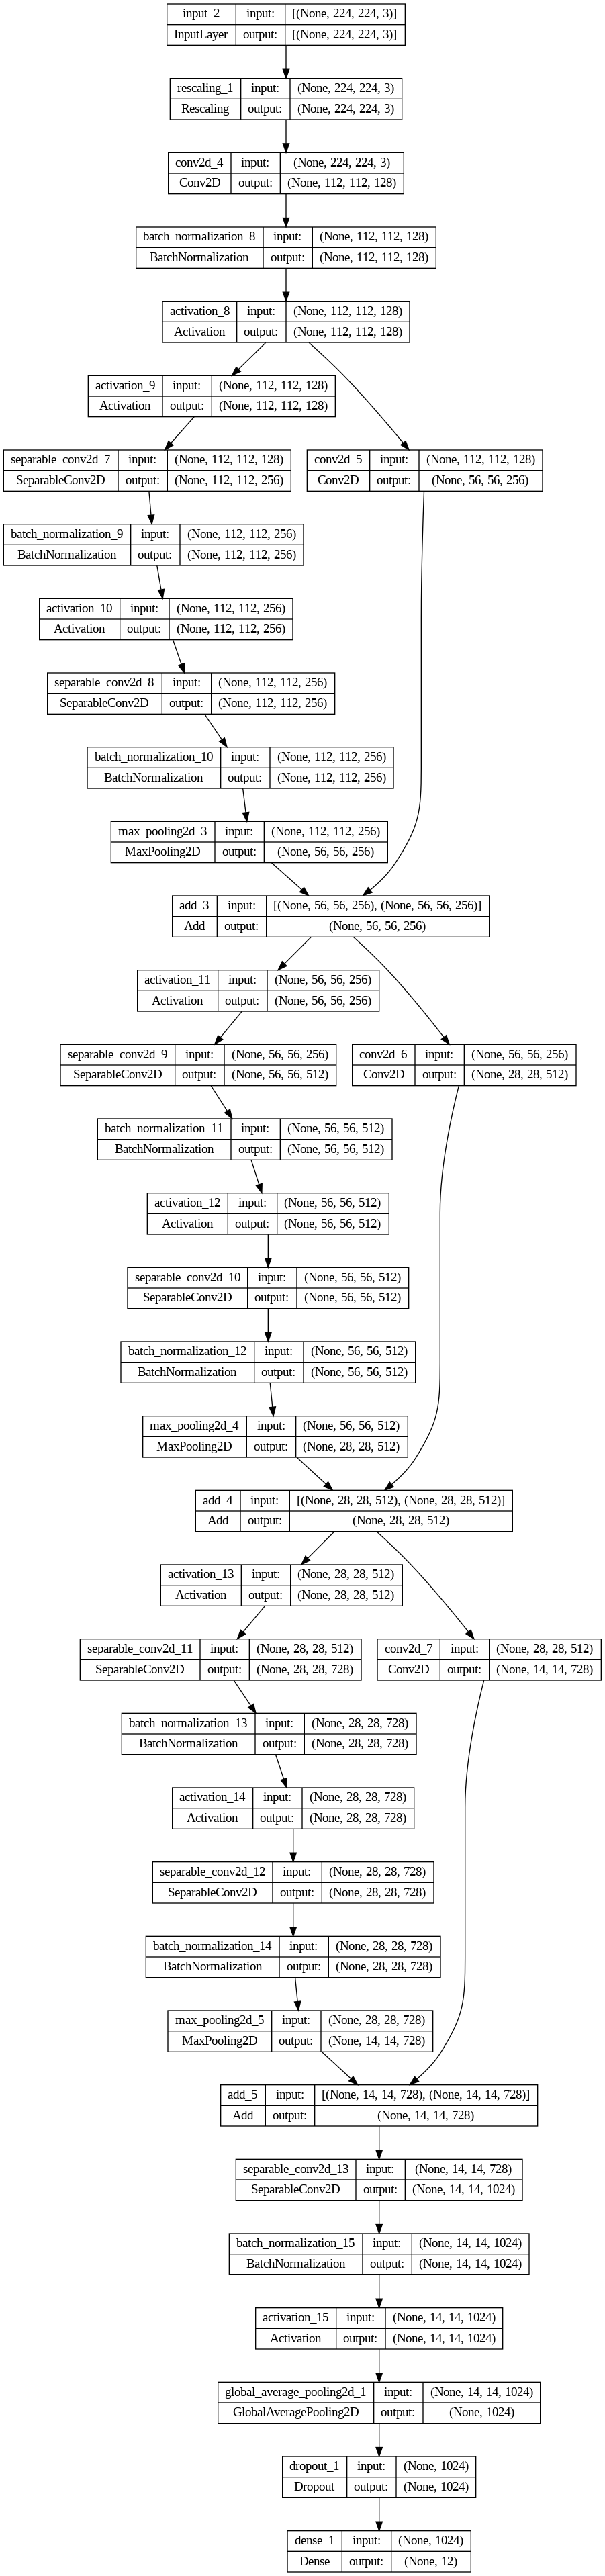

In [ ]:
# Training model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(224, 224) + (3,), num_classes=12)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

In [ ]:
#Train the model

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="CategoricalCrossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    verbose=1,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
plot_training(history)

In [ ]:
model.save(f"/content/drive/MyDrive/classifier.h5")

In [ ]:
model.save(f"/content/drive/MyDrive/classifiers")

In [ ]:
model.save_weights(f"/content/drive/MyDrive/classifier_weights")